In [1]:
## Import basic modules and routines
from __future__ import division, absolute_import, print_function

Simulating beam mismatches (deep scans)
====

This notebook treats about the simulation of beam mismatches.

**Motivation for simplification**

A full treatment of beam mismatches would require to convolve the beam response with the simulated CMB sky. That is one would have to rotate the grid that defines the beam geometry on a sphere for every telescope pointing defined by the scanning strategy and do the convolution... a nightmare if you have O(10k) detectors and long scans It is based on analytical considerations as described below.

**Avoiding convolutions!**

The pipeline adopts the following approach:
* For each detector of the focal plane, start with Gaussian circular 2D beam with width $ \sigma $.
* Perturbed these beams following:
 * Introduce ellipticity $ e = (\sigma_{\rm maj}^2 - \sigma_{\rm min}^2)/(\sigma_{\rm maj}^2 + \sigma_{\rm min}^2) $, where $ \sigma_{\rm maj/min} $ are the size of the semi-major and semi-minor axes in an elliptical Gaussian representation of the beam.
 * Rotate the beams around their center by an angle $ \epsilon $
 * If wanted, shift the center of the beams by a vector $ \textbf{$\rho$} = (\rho \cos{\epsilon}, \rho \sin{\epsilon}) $ (pointing error)

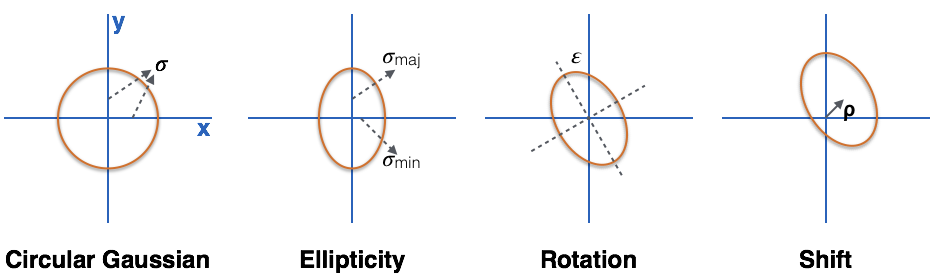

In [2]:
from IPython.display import Image
Image(filename='../data/beam_procedure.png')

Recall that the systematic pipeline uses pair difference to obtain polarisation timestreams, therefore differencing two bolometers with different beams will produce leakages (I, Q, and U from the two bolometers inside the pair won't be the same as they will be convolved with different beams). The resulting difference beam for the steps defined above is shown below (for one pixel containing 2 bolometers of the focal plane):

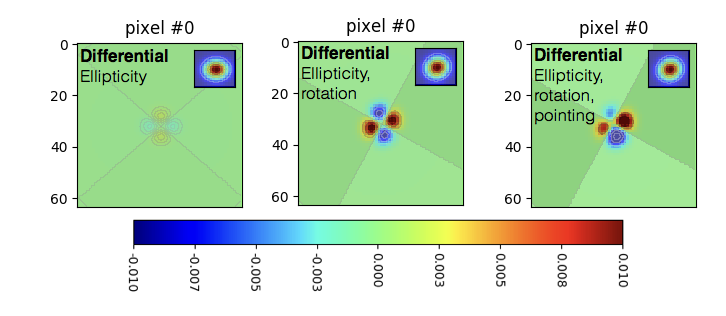

In [3]:
Image(filename='../data/beam_pair_procedure.png')

The parameters used for the perturbation of the beams are the following:
* We parametrize the semi-major and semi-minor axes of the ellipse to be $ \sigma_{\rm max/min} = \sigma \pm d/2$. For each detector beam, we assume ellipticity to be drawn from a normal distribution. Then we relate d to the ellipticity.
* For each detector beam, we draw a rotation from a uniform distribution between 0 and 360 degrees.
* For each pair of detector, we assume that the magnitude of the differential pointing is drawn from a normal distribution.

Let's take two (orthogonal) detectors inside a pair in the focal plane. One can model their timestreams $d_{t}$ and $d_{b}$ as

$$\begin{align}
d_t &= B_t \star (I + Q\cos{\phi} + U\sin{\phi}), \\
d_b &= B_b \star (I - Q\cos{\phi} - U\sin{\phi}).
\end{align}$$

$B_t$ and $B_b$ are the beam maps of the bolometers (I omit all angle dependencies). The temperature and polarisation timestreams are given by

$$\begin{align} 
d_{+} &= \big( \dfrac{B_t + B_b}{2} \big) \star I + \big( \dfrac{B_t - B_b}{2} \big) \star (Q\cos{\phi} + U\sin{\phi}) = B^{+} \star I + B^{-} \star (Q\cos{\phi} + U\sin{\phi}), \\
d_{-} &= \big( \dfrac{B_t - B_b}{2} \big) \star I + \big( \dfrac{B_t + B_b}{2} \big) \star (Q\cos{\phi} + U\sin{\phi}) = B^{-} \star I + B^{+} \star (Q\cos{\phi} + U\sin{\phi}). 
\end{align}$$

Focusing on the last equation, T->P leakage is the convolution of the temperature with the parallactic angle rotated beam. 
To estimate this effect, we would have then to perform convolutions for all detectors in the focal plane. No way unless you want to burn thousands and thousands of hours at NERSC.
So what can we do instead? 

Let's first notice that the observed temperature map $I^{\rm obs}$ is the convolution of the true temperature map $I$ with the sum beam $B^{+}$. Then, notice that the T->P leakage $L$ is the convolution of the true temperature map with difference beam $B^{-}$. To close the loop, one would need an operator $K$ to go from the observed temperature map to the T->P leakage. Summarizing this blabla into equations, one obtains

$$\begin{align}
I^{\rm obs} &= I \star B^{+} \\
L &= I \star B^{-} \\
L &= K \star I^{\rm obs}.
\end{align}$$

We then obtain $K = (B^{+})^{-1} \star B^{-}$. This is not super obvious to compute because of the inversion of the sum beam (ill-conditioned). So instead we need to find a representation of $K$ such that 

$$\begin{equation}
B^{-} = K \star B^{+}.
\end{equation}$$

This equation means that we need to find a way of expressing the difference beam in terms of the sum beam. This can be done by noticing that the spatial pattern of the leakage is a combination of zero, first and second order gradients for elliptical Gaussian beams. So let's define $K$ as

$$\begin{align}
K = \vec{a} . \vec{D}
\end{align}$$

where $\vec{D} = (1, \partial_x, \partial_y,\partial_x^2, \partial_y^2,\partial_{x}\partial_y)$, and $\vec{a}$ is a vector of scalar coefficients that has to be computed for each pair of detectors using Eq. 4. Then going back to Eq. 2, one finally obtains

$$\begin{align}
d_{-} &= B^{-} \star I + B^{+} \star (Q\cos{\phi} + U\sin{\phi}) \\
&\approx (\vec{a} . \vec{D})(I \star B^{+}) + B^{+} \star (Q\cos{\phi} + U\sin{\phi}) \\
&\approx (\vec{a} . \vec{D}) I^{\rm obs} + Q^{\rm obs}\cos{\phi} + U^{\rm obs}\cos{\phi}.
\end{align}$$

Notice that in practice, we use $X^{\rm obs} = B^{+} \star X \approx B^{\rm gauss} \star I$ where $B^{\rm gauss}$ is the input Gaussian circular 2D beam to the pipeline (before perturbations).

So to summarize, the pipeline proceeds the following:
* For all detectors, and done once: compute the derivatives of the input observed temperature map ($\vec{D} I^{\rm obs}$)
* For each pair of detector in the focal plane:
 * Perturbed each detector beam as described above, and form sum and difference beam maps (in the detector frame). 
 * Estimate $\vec{a}$ using Eqs. 4 & 5.
 * Rotate the derivatives according to the beam orientation in the focal plane.
 * Insert leakage in the polarisation timestream following Eq. 6.

In [2]:
## In case you did not install properly the library 
## or didn't update your bashrc. (Do it later!)
import os
path_to_s4cmb = '../../s4cmb'
os.sys.path.insert(0, os.path.realpath(path_to_s4cmb))

import healpy as hp
import pylab as pl
import numpy as np

## Import modules and routines from s4cmb
from s4cmb.input_sky import HealpixFitsMap

from s4cmb.instrument import Hardware
from s4cmb.instrument import construct_beammap

from s4cmb.scanning_strategy import ScanningStrategy

from s4cmb.tod import TimeOrderedDataPairDiff
from s4cmb.tod import OutputSkyMap
from s4cmb.tod import partial2full

from s4cmb.systematics import waferts_add_diffbeam
from s4cmb.systematics import get_kernel_coefficients
from s4cmb.systematics import inject_beam_ellipticity
from s4cmb.systematics import derivs
from s4cmb.systematics import modify_beam_offsets

try:
    from tqdm import *
except ImportError:
    tqdm = lambda x: x

Flow is the following: sky + instrument + scanning strategy --> map2tod --> inject beam ellipticity --> tod2map.

Initialise our instrument, scanning strategy and input maps as seen in the Day 1 lectures. However, one needs first to precompute the derivatives of the intensity map:

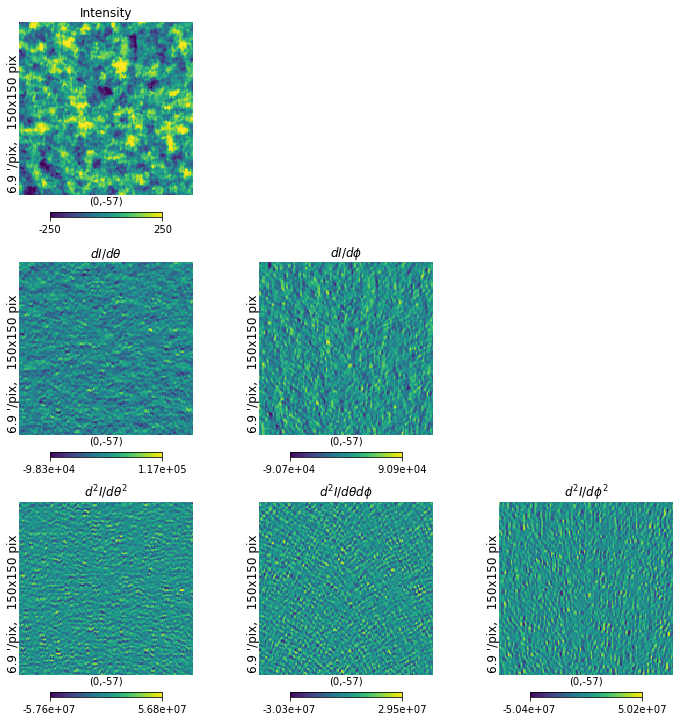

In [3]:
## Instrument
inst = Hardware(ncrate=4, ndfmux_per_crate=1,
                nsquid_per_mux=1, npair_per_squid=16,
                fp_size=60., fwhm=3.5, 
                beam_seed=58347, projected_fp_size=3., pm_name='5params',
                type_hwp='CRHWP', freq_hwp=2., angle_hwp=0., verbose=False)

## Input maps
nside = 512
path_to_cls = '../../s4cmb/s4cmb/data/test_data_set_lensedCls.dat'
sky_in = HealpixFitsMap(path_to_cls, do_pol=True, 
                        fwhm_in=inst.beam_model.fwhm, nside_in=nside, 
                        map_seed=5843787, verbose=False, compute_derivatives=True,
                        no_ileak=False, no_quleak=False)

xsize=150
reso=6.9

pl.figure(figsize=(10, 10))
hp.gnomview(sky_in.I, rot=[0, -57], 
            xsize=xsize, reso=reso,
            title='Intensity',
            min=-250, max=250, sub=331)
hp.gnomview(sky_in.dIdt, rot=[0, -57], 
            title='$dI/d\\theta$',
            xsize=xsize, reso=reso, sub=334)
hp.gnomview(sky_in.dIdp, rot=[0, -57], 
            title='$dI/d\\phi$',
            xsize=xsize, reso=reso, sub=335)
hp.gnomview(sky_in.d2Id2t, rot=[0, -57], 
            title='$d^2I/d\\theta^2$',
            xsize=xsize, reso=reso, sub=337)
hp.gnomview(sky_in.d2Idpdt, rot=[0, -57], 
            title='$d^2I/d\\theta d\\phi$',
            xsize=xsize, reso=reso, sub=338)
hp.gnomview(sky_in.d2Id2p, rot=[0, -57], 
            title='$d^2I/d\\phi^2$',
            xsize=xsize, reso=reso, sub=339)
pl.show()

In [4]:
## Scanning strategy
scan = ScanningStrategy(nces=12, start_date='2013/1/1 00:00:00',
                        telescope_longitude='-67:46.816',
                        telescope_latitude='-22:56.396', telescope_elevation=5200.,
                        name_strategy='deep_patch', sampling_freq=8., sky_speed=0.4,
                        ut1utc_fn='../../s4cmb/s4cmb/data/ut1utc.ephem', 
                        language='fortran')
scan.run()

Let's now inject beam ellipticity and differential beam ellipticity (one could add differential pointing as well, but I need to fix couple of things):

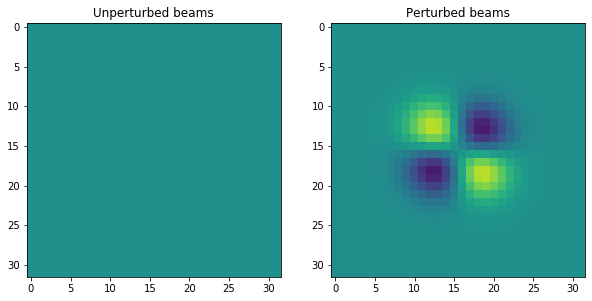

In [5]:
## Generate beam ellipticity (10% \pm 5%)
sig_1, sig_2, ellip_ang = inject_beam_ellipticity(
    inst.beam_model.sig_1[0], 10, 5, 
    inst.focal_plane.nbolometer, 
    do_diffbeamellipticity=True)

## Just for visualisation
fig, ax = pl.subplots(1, 2, figsize=(10, 5))
pix_size = 0.5 / 60. * np.pi / 180.
nx = 32

summap, diffmap = construct_beammap(inst.beam_model, 0, 1, nx, pix_size)
ax[0].imshow(diffmap, vmin=-0.2, vmax=0.2)
ax[0].set_title('Unperturbed beams')

inst.beam_model.sig_1 = sig_1
inst.beam_model.sig_2 = sig_2
inst.beam_model.ellip_ang = ellip_ang

summap, diffmap = construct_beammap(inst.beam_model, 0, 1, nx, pix_size)
ax[1].imshow(diffmap, vmin=-0.05, vmax=0.05)
ax[1].set_title('Perturbed beams')

pl.show()

Let's now generate our TOD from our input sky, instrument, and scanning strategy We will use the difference of pairs of detectors to reconstruct the polarisation (no demodulation).
Once we will have the timestreams, we will reconstruct our maps on a sky patch of width 130 deg at a resolution nside = 512.

In [8]:
## Noiseless simulations
array_noise_level = 0.0

state_for_noise = np.random.RandomState(3)
seeds_for_noise = state_for_noise.randint(0, 1e6, scan.nces)

## Loop over scans
for CESnumber in range(scan.nces):
    ## Note that we specify that we want to map pairs
    ## one-by-one by setting mapping_perpair to True. This is 
    ## very useful if you have no det-to-det correlations and 
    ## you want to save memory by not storing all timestreams
    ## in the memory.
    tod = TimeOrderedDataPairDiff(
        inst, scan, sky_in, CESnumber=CESnumber, 
        projection='healpix', 
        nside_out=nside, 
        width=130.,
        array_noise_level=array_noise_level,
        array_noise_seed=seeds_for_noise[CESnumber],
        mapping_perpair=True)
    
    ## Initialise map containers
    if CESnumber == 0:
        sky = OutputSkyMap(
            projection=tod.projection, 
            nside=tod.nside_out, 
            obspix=tod.obspix)
        ## Collect intensity derivatives, be careful with the order!
        ## NOTE: you need to pass only the maps with the pixels belonging to the observed field
        ## to simulate the leakage, not the full sky maps. You can alternatively define the sky_in.dIdt...sky_ind2Id2p
        ## beforehand to save memory.
        intensity_derivatives = np.array(
            [sky_in.I[tod.obspix], sky_in.dIdt[tod.obspix], sky_in.dIdp[tod.obspix], 
             sky_in.d2Idpdt[tod.obspix], sky_in.d2Id2t[tod.obspix], sky_in.d2Id2p[tod.obspix]])        
    ## For visualisation
    Ktot = []
    ## Scan input map to get TODs
    ## Do it pair-by-pair to save memory for large runs.
    for pair in tqdm(tod.pair_list):
        ## Get the TOD
        d = np.array([tod.map2tod(det) for det in pair])
        
        ## Compute beam kernel coefficients
        K = get_kernel_coefficients(inst.beam_model, [pair])
        Ktot.append(K)
        
        ## Get spurious signal from beam mismatch
        beam_orientation = tod.return_parallactic_angle(pair[0])
        waferts_add_diffbeam(
            waferts=d, 
            point_matrix=tod.point_matrix, 
            beam_orientation=beam_orientation,
            intensity_derivatives=intensity_derivatives, 
            diffbeam_kernels=K,
            pairlist=pair, 
            spins='012')
        
        ## Project TOD to maps
        tod.tod2map(d, sky)

Let's quickly check our beam approximation:

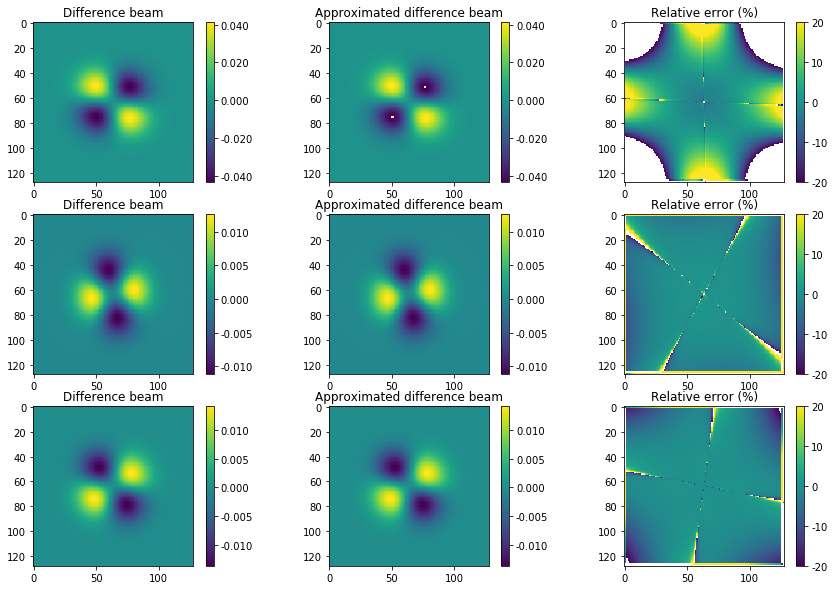

In [9]:
pix_size = 0.8 / 7. / 60. * np.pi / 180.
nx = 128

fig,ax = pl.subplots(3,3,figsize=(15,10))
for i in range(3):
    summap, diffmap = construct_beammap(
        inst.beam_model, 2*i, 2*i+1, nx, pix_size)
    
    der = derivs(summap, pix_size)
    der = der.reshape((6, summap.shape[0] * summap.shape[1]))
    diffmap_approx = np.dot(Ktot[i][0], der).reshape((nx, nx))
    
    obj1 = ax[i, 0].imshow(
        diffmap, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 0].set_title('Difference beam')
    fig.colorbar(
        obj1, ax=ax[i, 0], 
        orientation='vertical', shrink=1., format='%.3f')
    
    obj2 = ax[i, 1].imshow(
        diffmap_approx, vmin=np.min(diffmap), vmax=np.max(diffmap), aspect='equal')
    ax[i, 1].set_title('Approximated difference beam')
    fig.colorbar(
        obj2, ax=ax[i, 1], 
        orientation='vertical', shrink=1., format='%.3f')
    
    obj3 = ax[i, 2].imshow(
        (diffmap - diffmap_approx)/diffmap*100, 
        vmin=-20, vmax=20, aspect='equal')
    ax[i,2].set_title('Relative error (%)')
    fig.colorbar(
        obj3, ax=ax[i, 2], 
        orientation='vertical', shrink=1., format='%.0f')
pl.show()

Not bad at all! Few % difference on the core. Large deviations happen in low SNR regions.
Let's check the output maps now:

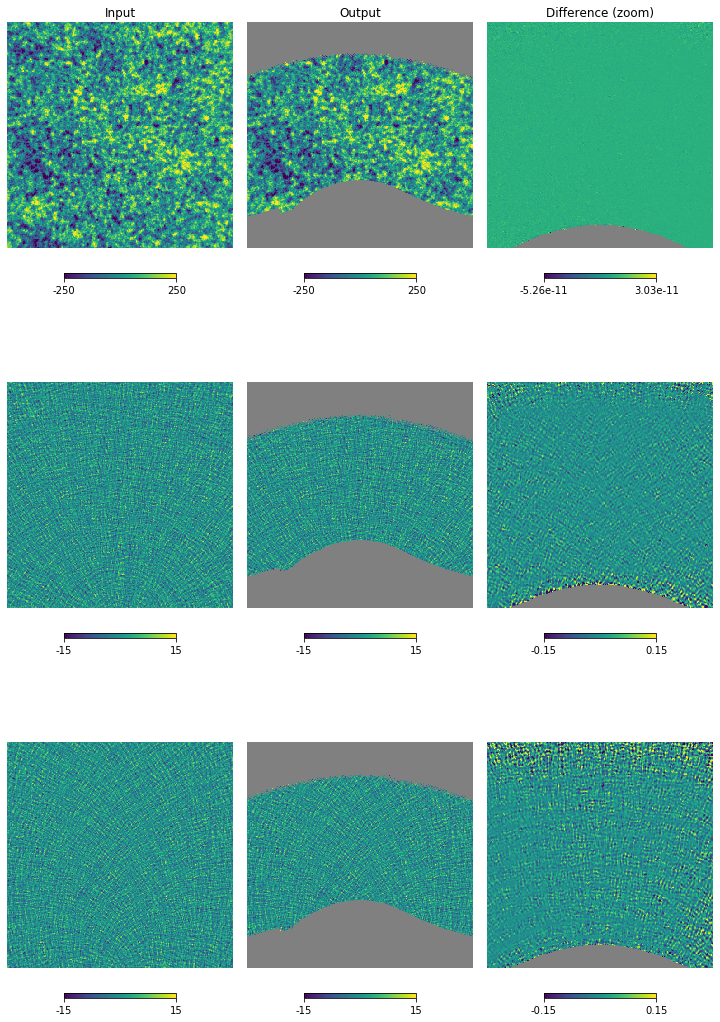

In [19]:
np.seterr(divide='ignore',invalid='ignore')


xsize = 500
fig = pl.figure(figsize=(10, 15))

nhit = partial2full(
    sky.nhit, 
    sky.obspix, 
    sky.nside, fill_with=0.0)

## Temperature
sky_out = partial2full(
    sky.get_I(), 
    sky.obspix, 
    sky.nside, fill_with=0.0)

mask = nhit < 1
sky_out[mask] = np.nan

hp.gnomview(sky_in.I, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=331, 
            title='Input', notext=True, min=-250, max=250)
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=332, 
            title='Output', notext=True, min=-250, max=250)
hp.gnomview(sky_in.I - sky_out, rot=[0, -57.5], 
            xsize=xsize/2, reso=6.9, sub=333, 
            title='Difference (zoom in)', notext=True)

## Stokes Q
sky_out = partial2full(
    sky.get_QU()[0], 
    sky.obspix, 
    sky.nside, fill_with=0.0)

mask = nhit < 10
sky_out[mask] = np.nan
hp.gnomview(sky_in.Q, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=334, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=335,  
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_in.Q - sky_out, rot=[0, -57.5], 
            xsize=xsize/2, reso=6.9, sub=336, 
            notext=True, title='', min=-0.15, max=0.15)

## Stokes U
sky_out = partial2full(
    sky.get_QU()[1], 
    sky.obspix, 
    sky.nside, fill_with=0.0)

mask = nhit < 10
sky_out[mask] = np.nan

hp.gnomview(sky_in.U, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=337, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_out, rot=[0, -57.5], xsize=xsize, reso=6.9, sub=338, 
            notext=True, min=-15, max=15, title='')
hp.gnomview(sky_in.U - sky_out, rot=[0, -57.5], 
            xsize=xsize/2, reso=6.9, sub=339, 
            notext=True, title='', min=-0.15, max=0.15)
pl.show()

Note that only polarisation is affected in this model.